# Token classification (PyTorch)

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
!pip install -U pyarrow
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs
!pip install seqeval

ERROR: Operation cancelled by user


# Loading and Viewing Dataset

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
from datasets import load_dataset

raw_datasets = load_dataset("ai4privacy/pii-masking-200k", data_files=["english_pii_43k.jsonl"])

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['masked_text', 'unmasked_text', 'privacy_mask', 'span_labels', 'bio_labels', 'tokenised_text'],
        num_rows: 43501
    })
})

In [9]:
raw_datasets["train"][101]["unmasked_text"]

"Ethics case 101: The unauthorized disclosure of an 87 years old Trans female's 280-41-6336, 14/01/1905 data. Expect a detailed analysis on this in the next meeting."

In [10]:
raw_datasets["train"][101]["masked_text"]

"Ethics case 101: The unauthorized disclosure of an [AGE_1] old [GENDER_1]'s [SSN_1], [DOB_1] data. Expect a detailed analysis on this in the next meeting."

In [11]:
print(raw_datasets["train"][101]["privacy_mask"])

{'[AGE_1]': '87 years', '[GENDER_1]': 'Trans female', '[SSN_1]': '280-41-6336', '[DOB_1]': '14/01/1905'}


In [12]:
print(raw_datasets["train"][101]["span_labels"])

[[0, 51, 'O'], [51, 59, 'AGE_1'], [59, 64, 'O'], [64, 76, 'GENDER_1'], [76, 79, 'O'], [79, 90, 'SSN_1'], [90, 92, 'O'], [92, 102, 'DOB_1'], [102, 164, 'O']]


In [13]:
print(raw_datasets["train"][101]["tokenised_text"])

['ethics', 'case', '101', ':', 'the', 'unauthorized', 'disclosure', 'of', 'an', '87', 'years', 'old', 'trans', 'female', "'", 's', '280', '-', '41', '-', '63', '##36', ',', '14', '/', '01', '/', '1905', 'data', '.', 'expect', 'a', 'detailed', 'analysis', 'on', 'this', 'in', 'the', 'next', 'meeting', '.']


### Labels per token in BIO format


In [14]:
print(raw_datasets["train"][101]["bio_labels"])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AGE', 'I-AGE', 'O', 'B-GENDER', 'I-GENDER', 'O', 'O', 'B-SSN', 'I-SSN', 'I-SSN', 'I-SSN', 'I-SSN', 'I-SSN', 'O', 'B-DOB', 'I-DOB', 'I-DOB', 'I-DOB', 'I-DOB', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [15]:
raw_datasets["train"][101]["unmasked_text"]

"Ethics case 101: The unauthorized disclosure of an 87 years old Trans female's 280-41-6336, 14/01/1905 data. Expect a detailed analysis on this in the next meeting."

## Distribution of Lables in Dataset

In [16]:
from collections import Counter,OrderedDict
def get_distribution_of_labels(mask_list):
  total_label_count = Counter()
  for masks in mask_list:
      labels = list(masks.keys())
      labels = [label.strip("[]").split("_")[0] for label in labels]
      total_label_count.update(Counter(labels))
  return OrderedDict(total_label_count.most_common())

total_label_count = get_distribution_of_labels([eval(x["privacy_mask"]) for x in raw_datasets["train"]])

In [17]:
total_label_count

OrderedDict([('FIRSTNAME', 13323),
             ('LASTNAME', 4817),
             ('DATE', 4555),
             ('EMAIL', 4092),
             ('PREFIX', 3446),
             ('AMOUNT', 3103),
             ('USERNAME', 3056),
             ('JOBTITLE', 2954),
             ('URL', 2910),
             ('TIME', 2883),
             ('JOBAREA', 2882),
             ('MIDDLENAME', 2881),
             ('ACCOUNTNUMBER', 2831),
             ('STREET', 2799),
             ('ACCOUNTNAME', 2793),
             ('CITY', 2787),
             ('COUNTY', 2745),
             ('STATE', 2735),
             ('IPV4', 2720),
             ('BUILDINGNUMBER', 2714),
             ('JOBTYPE', 2710),
             ('CURRENCYSYMBOL', 2678),
             ('PASSWORD', 2622),
             ('SEX', 2606),
             ('CREDITCARDNUMBER', 2574),
             ('COMPANYNAME', 2502),
             ('PHONENUMBER', 2425),
             ('BITCOINADDRESS', 2403),
             ('IPV6', 2401),
             ('GENDER', 2385),
             (

<Axes: >

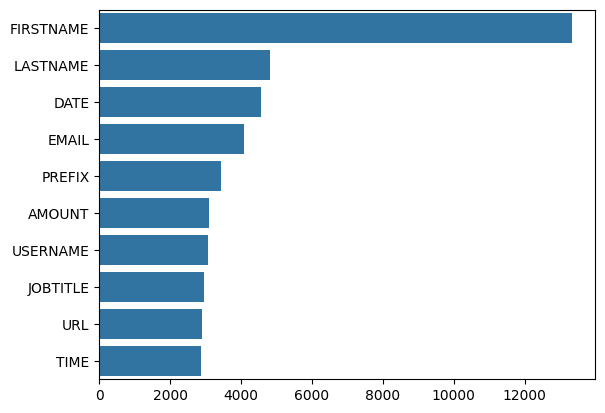

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(x=list(total_label_count.values())[:10], y=list(total_label_count.keys())[:10], orient="y")

# Filter Samples with only required Tags

In [19]:
import json
import ast
REQUIRED_TAGS = ['FIRSTNAME','MIDDLENAME','EMAIL', 'LASTNAME', 'CREDITCARDNUMBER', 'ZIPCODE', 'SSN', 'PHONENUMBER','CREDITCARDCVV']
from datasets import load_dataset

def filter_privacy_masks(row):
    try:
      mask_dict = ast.literal_eval(row['privacy_mask'])
      row['privacy_mask'] = json.dumps(mask_dict)
      new_mask_dict = {key:value for key, value in mask_dict.items() if key.strip('[]').split('_')[0] in REQUIRED_TAGS}
      row['new_privacy_mask'] = json.dumps(new_mask_dict)
      return row
    except Exception as e:
      print(e)
      row['new_privacy_mask'] = {}
      return row

new_mask_raw_dataset = raw_datasets.map(filter_privacy_masks, num_proc=4)
filtered_new_mask_raw_dataset = new_mask_raw_dataset.filter( lambda x : len(json.loads(x['new_privacy_mask'])) > 0)

Map (num_proc=4):   0%|          | 0/43501 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43501 [00:00<?, ? examples/s]

# Re filling Masked text of unwanted Labels

In [20]:
filtered_new_mask_raw_dataset["train"][100]["masked_text"]

'[FIRSTNAME_1], please check your company email [EMAIL_1] regularly for updates and news from the [JOBAREA_1] team. Your new journey with us begins today!'

In [21]:
filtered_new_mask_raw_dataset["train"][100]["privacy_mask"]

'{"[FIRSTNAME_1]": "Jamey", "[EMAIL_1]": "Madonna83@yahoo.com", "[JOBAREA_1]": "Metrics"}'

In [22]:
filtered_new_mask_raw_dataset["train"][100]["new_privacy_mask"]

'{"[FIRSTNAME_1]": "Jamey", "[EMAIL_1]": "Madonna83@yahoo.com"}'

In [23]:
class TextLabeler():
    def __init__(self, text, lod):
        self.text = text
        self.iterate(lod)

    def replace_kv(self, _dict):
        """Replace any occurrence of a value with the key"""
        for key, value in _dict.items():
          self.text = self.text.replace(key,value)
        return self.text

    def iterate(self, lod):
        """Iterate over each dict object in a given list of dicts, `lod` """

        self.text = self.replace_kv(lod)

def fill_unwanted_masks(example):
  old_mask_map = json.loads(example['privacy_mask'])
  new_mask_map = json.loads(example['new_privacy_mask'])
  replace_masks = {key : old_mask_map[key] for key in set(old_mask_map.keys()) - set(new_mask_map.keys())}
  processed = TextLabeler(example['masked_text'], replace_masks)
  example['new_masked_text'] = processed.text
  return(example)

new_mask_raw_dataset = filtered_new_mask_raw_dataset.map(lambda x: fill_unwanted_masks(x), num_proc=4)

Map (num_proc=4):   0%|          | 0/24233 [00:00<?, ? examples/s]

In [24]:
new_mask_raw_dataset["train"][100]["masked_text"]

'[FIRSTNAME_1], please check your company email [EMAIL_1] regularly for updates and news from the [JOBAREA_1] team. Your new journey with us begins today!'

In [25]:
new_mask_raw_dataset["train"][100]["new_masked_text"]

'[FIRSTNAME_1], please check your company email [EMAIL_1] regularly for updates and news from the Metrics team. Your new journey with us begins today!'

# Align Labels with Input Tokens

In [26]:
from transformers import AutoTokenizer

model_checkpoint = "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [27]:
new_mask_raw_dataset["train"][100]["unmasked_text"]

'Jamey, please check your company email Madonna83@yahoo.com regularly for updates and news from the Metrics team. Your new journey with us begins today!'

In [28]:
print(tokenizer(new_mask_raw_dataset["train"][100]["unmasked_text"],add_special_tokens = False)["input_ids"])
print(len(tokenizer(new_mask_raw_dataset["train"][100]["unmasked_text"],add_special_tokens = False)["input_ids"]))

[108249, 261, 811, 807, 290, 483, 871, 23411, 9748, 1683, 33509, 260, 549, 2958, 270, 2797, 263, 984, 292, 262, 54529, 511, 260, 730, 353, 1930, 275, 381, 2979, 561, 300]
31


In [29]:
print(new_mask_raw_dataset["train"][100]["bio_labels"])
print(len(new_mask_raw_dataset["train"][100]["bio_labels"]))

['B-FIRSTNAME', 'I-FIRSTNAME', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EMAIL', 'I-EMAIL', 'I-EMAIL', 'I-EMAIL', 'I-EMAIL', 'I-EMAIL', 'I-EMAIL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-JOBAREA', 'I-JOBAREA', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
34


In [30]:
print(tokenizer.decode([108249]))
print(tokenizer.decode([261]))
print(tokenizer.decode([811]))

Jamey
,
please


In [31]:
new_mask_raw_dataset["train"][100]['tokenised_text'][:3]

['jam', '##ey', ',']

In [32]:
new_mask_raw_dataset["train"][100]["new_privacy_mask"]

'{"[FIRSTNAME_1]": "Jamey", "[EMAIL_1]": "Madonna83@yahoo.com"}'

In [33]:
tokenizer("Madonna83@yahoo.com",add_special_tokens = False)["input_ids"]

[23411, 9748, 1683, 33509, 260, 549]

In [34]:
LABELS = ['O', 'B-FIRSTNAME', 'I-FIRSTNAME', 'B-MIDDLENAME', 'I-MIDDLENAME','B-EMAIL', 'I-EMAIL', 'B-LASTNAME', 'I-LASTNAME', 'B-CREDITCARDNUMBER', 'I-CREDITCARDNUMBER', 'B-ZIPCODE', 'I-ZIPCODE', 'B-SSN', 'I-SSN','B-PHONENUMBER', 'I-PHONENUMBER', 'B-CREDITCARDCVV', 'I-CREDITCARDCVV']

TAG_TO_LABEL = {
    'O': ['O'],
    'FIRSTNAME' : ['B-FIRSTNAME', 'I-FIRSTNAME'],
    'MIDDLENAME' : ['B-MIDDLENAME', 'I-MIDDLENAME'],
    'EMAIL' : ['B-EMAIL', 'I-EMAIL'],
    'LASTNAME' : ['B-LASTNAME', 'I-LASTNAME'],
    'CREDITCARDNUMBER' : ['B-CREDITCARDNUMBER', 'I-CREDITCARDNUMBER'],
    'ZIPCODE' : ['B-ZIPCODE', 'I-ZIPCODE'],
    'SSN' : ['B-SSN', 'I-SSN'],
    'PHONENUMBER' : ['B-PHONENUMBER', 'I-PHONENUMBER'],
    'CREDITCARDCVV' : ['B-CREDITCARDCVV', 'I-CREDITCARDCVV']
}

id2label = {i:val for i,val in enumerate(LABELS)}

label2id= {val:i for i,val in enumerate(LABELS)}

In [35]:
label2id

{'O': 0,
 'B-FIRSTNAME': 1,
 'I-FIRSTNAME': 2,
 'B-MIDDLENAME': 3,
 'I-MIDDLENAME': 4,
 'B-EMAIL': 5,
 'I-EMAIL': 6,
 'B-LASTNAME': 7,
 'I-LASTNAME': 8,
 'B-CREDITCARDNUMBER': 9,
 'I-CREDITCARDNUMBER': 10,
 'B-ZIPCODE': 11,
 'I-ZIPCODE': 12,
 'B-SSN': 13,
 'I-SSN': 14,
 'B-PHONENUMBER': 15,
 'I-PHONENUMBER': 16,
 'B-CREDITCARDCVV': 17,
 'I-CREDITCARDCVV': 18}

### KMP SEARCH ALGORITHM

In [36]:
def KMPSearch(label_ids, text_ids):
    M = len(label_ids)
    N = len(text_ids)

    # create lps[] that will hold the longest prefix suffix
    # values for pattern
    lps = [0]*M
    j = 0  # index for pat[]

    # Preprocess the pattern (calculate lps[] array)
    computeLPSArray(label_ids, M, lps)

    i = 0  # index for txt[]
    while (N - i) >= (M - j):
        if label_ids[j] == text_ids[i]:
            i += 1
            j += 1

        if j == M:
            return(i-j)
            # j = lps[j-1]

        # mismatch after j matches
        elif i < N and label_ids[j] != text_ids[i]:
            # Do not match lps[0..lps[j-1]] characters,
            # they will match anyway
            if j != 0:
                j = lps[j-1]
            else:
                i += 1


# Function to compute LPS array
def computeLPSArray(pat, M, lps):
    len = 0  # length of the previous longest prefix suffix

    lps[0] = 0  # lps[0] is always 0
    i = 1

    # the loop calculates lps[i] for i = 1 to M-1
    while i < M:
        if pat[i] == pat[len]:
            len += 1
            lps[i] = len
            i += 1
        else:
            # This is tricky. Consider the example.
            # AAACAAAA and i = 7. The idea is similar
            # to search step.
            if len != 0:
                len = lps[len-1]

                # Also, note that we do not increment i here
            else:
                lps[i] = 0
                i += 1

### Align Targets with tokens after tokeinizing

In [37]:
def encode_align_targets(row):
    """
    Aligns the target labels based on word IDs, ensuring that words split into multiple tokens
    correctly transition from B- tags to I- tags.
    """
    original_text,new_privacy_mask = row['unmasked_text'],json.loads(row['new_privacy_mask'])
    encoded_text = tokenizer(original_text,max_length=512,truncation =True)
    masked_input_labels = ['O']*len(encoded_text.input_ids[1:])

    for key in new_privacy_mask.keys():
      ids = tokenizer(new_privacy_mask[key]).input_ids[1:-1]
      labels = TAG_TO_LABEL[key.strip('[]').split('_')[0]]
      id_labels = [labels[0]] + [labels[1]]*(len(ids) -1)
      try:
        found_indx = KMPSearch(ids, encoded_text.input_ids[1:])
        masked_input_labels = masked_input_labels[:found_indx] + id_labels + masked_input_labels[found_indx + len(id_labels)+1:]
      except:
        pass

    masked_input_ids = [label2id[label] for label in masked_input_labels]
    masked_input_ids = [-100] + masked_input_ids # -100 is for CLS Token
    return {
        "input_ids" : encoded_text['input_ids'],
        "attention_mask" : encoded_text['attention_mask'],
        "labels" : masked_input_ids
    }

dataset = new_mask_raw_dataset.map(encode_align_targets, num_proc=1)
dataset = dataset.with_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/24233 [00:00<?, ? examples/s]

# Train Test Split

In [38]:
dataset = dataset['train'].train_test_split(test_size=0.15)

In [39]:
dataset

DatasetDict({
    train: Dataset({
        features: ['masked_text', 'unmasked_text', 'privacy_mask', 'span_labels', 'bio_labels', 'tokenised_text', 'new_privacy_mask', 'new_masked_text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 20598
    })
    test: Dataset({
        features: ['masked_text', 'unmasked_text', 'privacy_mask', 'span_labels', 'bio_labels', 'tokenised_text', 'new_privacy_mask', 'new_masked_text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3635
    })
})

# Custom Training Code

## Download Pretrained model

In [5]:
from transformers import AutoModelForTokenClassification
#Load model
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForTokenClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-5): 6 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True

In [ ]:
model.config

DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-FIRSTNAME",
    "2": "I-FIRSTNAME",
    "3": "B-MIDDLENAME",
    "4": "I-MIDDLENAME",
    "5": "B-EMAIL",
    "6": "I-EMAIL",
    "7": "B-LASTNAME",
    "8": "I-LASTNAME",
    "9": "B-CREDITCARDNUMBER",
    "10": "I-CREDITCARDNUMBER",
    "11": "B-ZIPCODE",
    "12": "I-ZIPCODE",
    "13": "B-SSN",
    "14": "I-SSN",
    "15": "B-PHONENUMBER",
    "16": "I-PHONENUMBER",
    "17": "B-CREDITCARDCVV",
    "18": "I-CREDITCARDCVV"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CREDITCARDCVV": 17,
    "B-CREDITCARDNUMBER": 9,
    "B-EMAIL": 5,
    "B-FIRSTNAME": 1,
    "B-LASTNAME": 7,
    "B-MIDDLENAME": 3,
    "B-PHONENUMBER": 15,
    "B-SSN": 13,
    "B-ZIPCODE": 11,
    "I-CREDITCARDCVV": 18,
    "I-CREDITCARDNUMBER": 10,
    "I-

In [49]:
import evaluate
import numpy as np
seqeval_metric = evaluate.load('seqeval')
def compute_metrics(logits_and_labels):
    """
    Compute sequence tagging metrics using the seqeval metric.

    Args:
    - logits_and_labels (tuple): A tuple containing model logits and true labels.

    Returns:
    - dict: A dictionary containing precision, recall, f1-score, and accuracy.
    """

    # Separate logits and labels from the input tuple
    logits, true_labels = logits_and_labels

    # Obtain predicted label indices by selecting the label with the highest logit value for each token
    predicted_indices = np.argmax(logits, axis=-1)  # Shape: (batch_size, sequence_length)

    # Convert label indices to their string representation, ignoring special tokens (label index = -100)
    string_true_labels = [[model.config.id2label[label_id] for label_id in sequence if label_id != -100] for sequence in true_labels]

    # Convert predicted indices to their string representation, but only for tokens where the true label isn't -100
    string_predictions = [
        [model.config.id2label[pred_id] for pred_id, true_label_id in zip(pred_sequence, true_sequence) if true_label_id != -100]
        for pred_sequence, true_sequence in zip(predicted_indices, true_labels)
    ]

    # Compute the metrics using seqeval
    metrics_results = seqeval_metric.compute(predictions=string_predictions, references=string_true_labels)

    return {
        'precision': metrics_results['overall_precision'],
        'recall': metrics_results['overall_recall'],
        'f1': metrics_results['overall_f1'],
        'accuracy': metrics_results['overall_accuracy']
    }

In [ ]:
# Define Optimizer to use
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [51]:
# Data Loader to load data seemlessy for every step or every batch in while training or evaluating
from torch.utils.data import DataLoader
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

train_dataloader = DataLoader(
    dataset["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    dataset["test"], collate_fn=data_collator, batch_size=16
)

In [ ]:
# Move model, optimzer and your training data to Accelerator (GPU in our case)
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 2
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[LABELS[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [LABELS[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

In [ ]:
from tqdm.auto import tqdm
import torch
import evaluate
output_dir = "./models/pos/dbert_custom"
metric = evaluate.load("seqeval")
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    # Get Batch from dataset
    for batch in train_dataloader:

        # Passing Batch through the model
        outputs = model(**batch)

        #Calculate Loss Vector
        loss = outputs.loss

        #Using Loss vector calculating Gradients
        accelerator.backward(loss)

        #Accelerator also has optimizer which uses this gradient to update parameters mt and vt in our example
        #Update weights of the model
        optimizer.step()

        #Update Learning rate for next iteration
        lr_scheduler.step()

        #Updates gradients to none or clears gradient of this step
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=true_predictions, references=true_labels)

    results = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    tokenizer.save_pretrained(output_dir)

  0%|          | 0/2576 [00:00<?, ?it/s]

epoch 0: {'precision': 0.9355464958260532, 'recall': 0.9046367561479257, 'f1': 0.9198320290131705, 'accuracy': 0.9935124196492342}
epoch 1: {'precision': 0.9539895165987187, 'recall': 0.923337091319053, 'f1': 0.9384130621598396, 'accuracy': 0.9948086130730366}


In [ ]:
import numpy as np
filtered_predictions_total= []
filtered_labels_total = []
model.eval()
for batch in eval_dataloader:
    with torch.no_grad():
        outputs = model(**batch)

    predictions = outputs.logits.argmax(dim=-1)
    predictions = predictions.detach().cpu().numpy()

    labels = batch["labels"]
    labels = labels.detach().cpu().numpy()
    # 2. Filter out any tokens with label -100 (typically used for padding or special tokens)
    mask = labels != -100
    filtered_predictions = predictions[mask]
    filtered_labels = labels[mask]
    filtered_predictions_total.append(filtered_predictions)
    filtered_labels_total.append(filtered_labels)


filtered_labels_total = np.concatenate(filtered_labels_total,axis = 0)
filtered_predictions_total = np.concatenate(filtered_predictions_total,axis = 0)

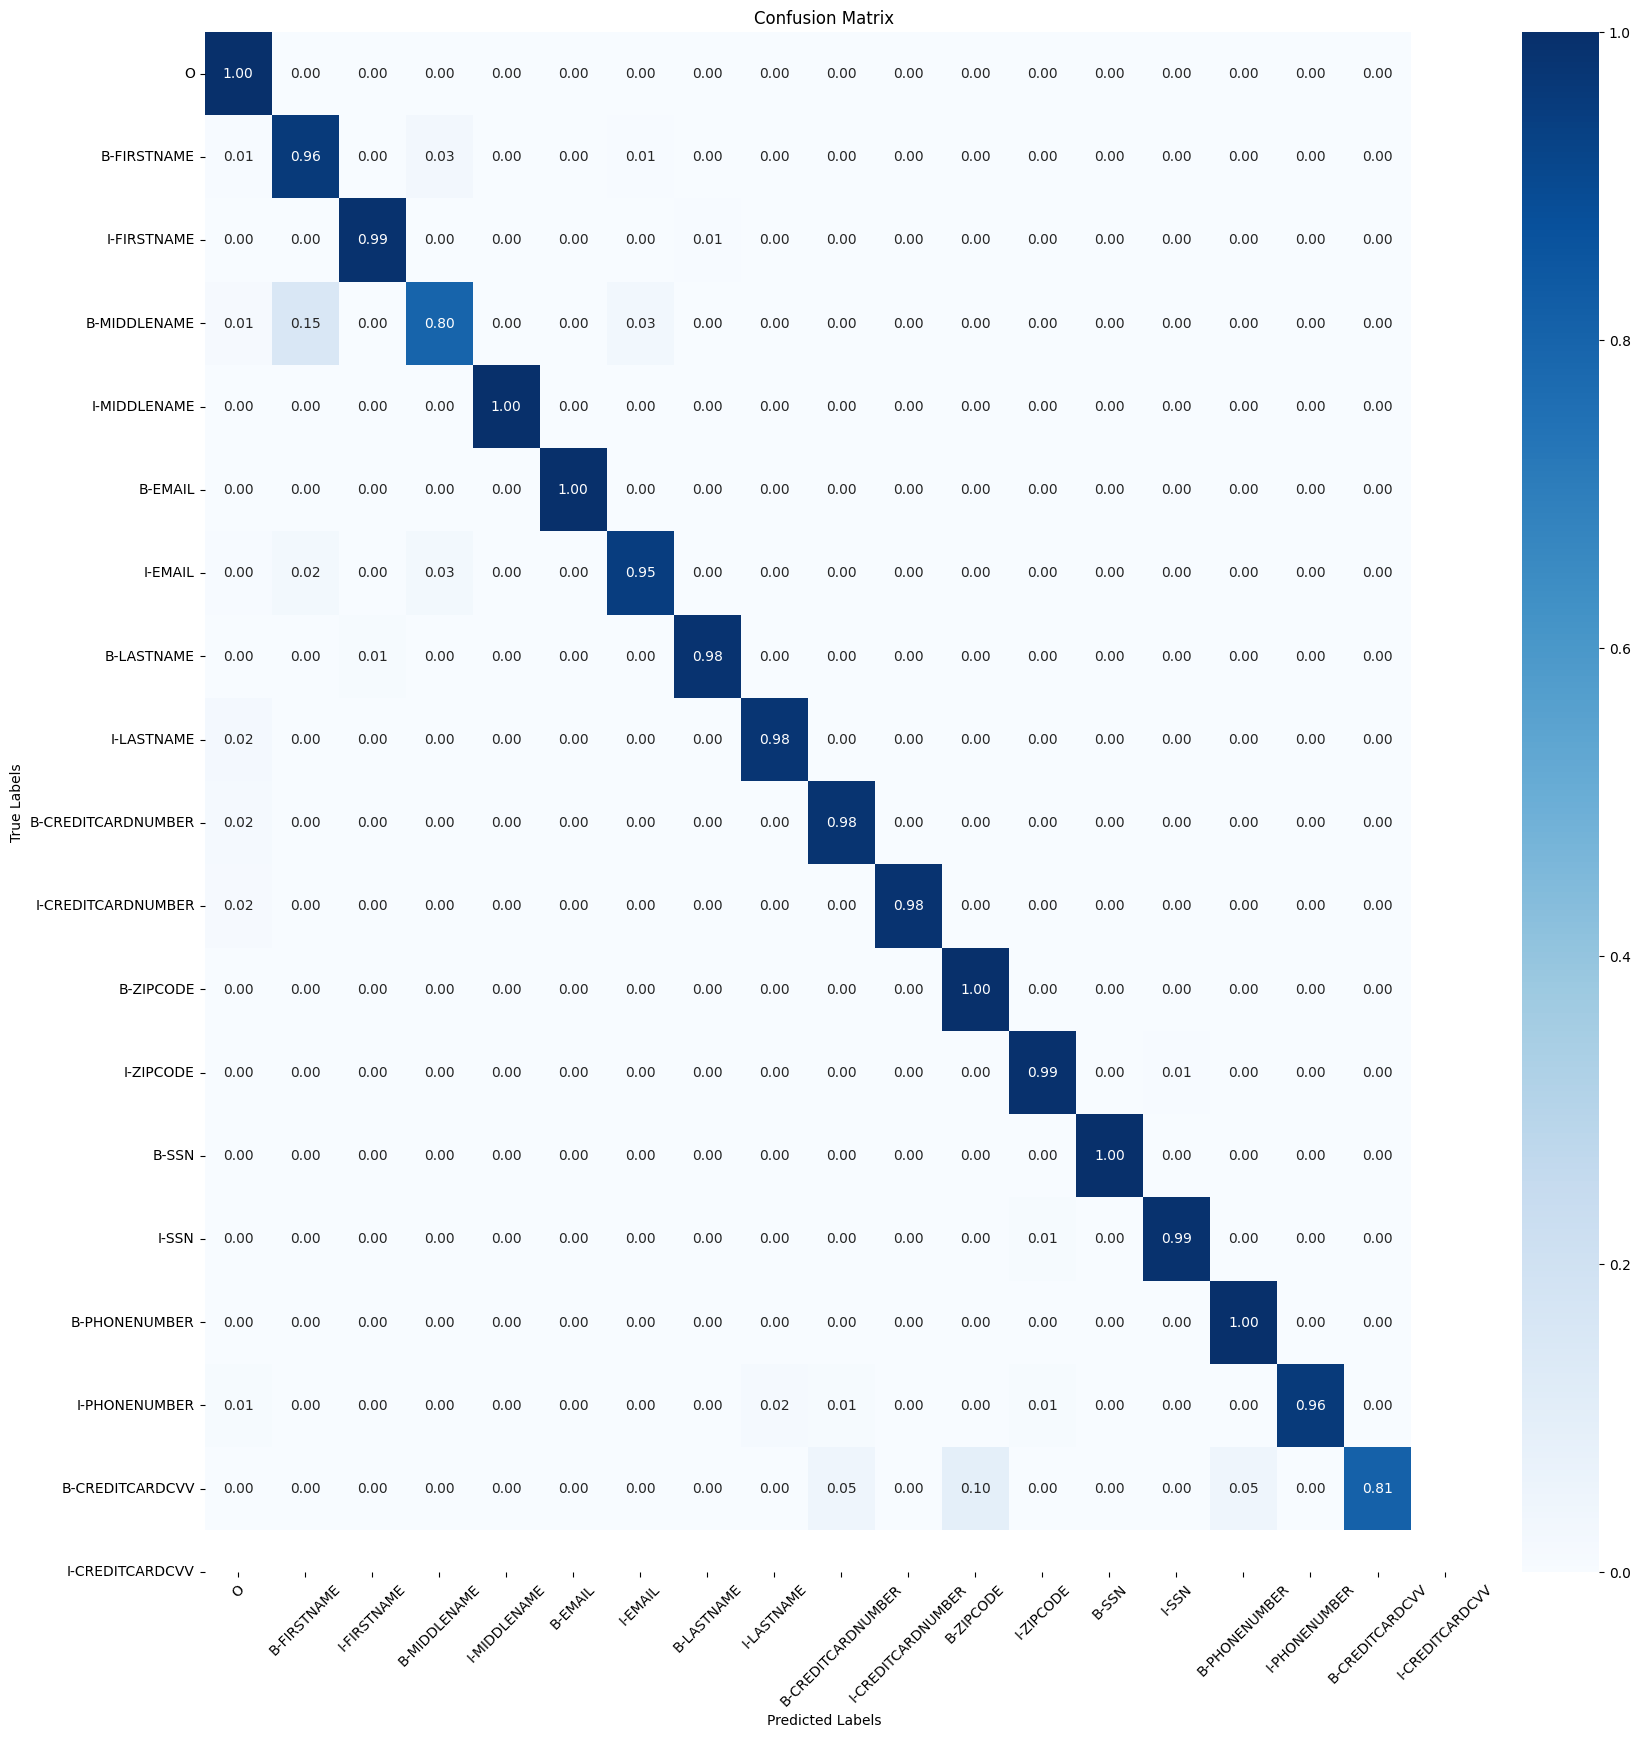

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#  Generate the confusion matrix
cm = confusion_matrix(filtered_labels_total, filtered_predictions_total,normalize='true')

# Plotting the confusion matrix
plt.figure(figsize=(20, 20))
ax= sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
# Ensure x-labels are vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Ensure y-labels are horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
 # CHANGE FOLDERS AS PER YOUR SETUP
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    base_folder = Path("/content/drive/MyDrive/data")

Mounted at /content/drive


# Model Training

## Model Config

In [40]:
from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer, Trainer, TrainingArguments
config = AutoConfig.from_pretrained(model_checkpoint)

In [41]:
config

DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.38.2",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

###Modify Configuration File


- We need to modify configuration fie to add ids to  label and label to ids mapping
- Adding id2label and label2id to the configuration file provides a consistent, interpretable, and user-friendly way to handle model outputs.

In [42]:
config.id2label = id2label
config.label2id = label2id

In [43]:
config

DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-FIRSTNAME",
    "2": "I-FIRSTNAME",
    "3": "B-MIDDLENAME",
    "4": "I-MIDDLENAME",
    "5": "B-EMAIL",
    "6": "I-EMAIL",
    "7": "B-LASTNAME",
    "8": "I-LASTNAME",
    "9": "B-CREDITCARDNUMBER",
    "10": "I-CREDITCARDNUMBER",
    "11": "B-ZIPCODE",
    "12": "I-ZIPCODE",
    "13": "B-SSN",
    "14": "I-SSN",
    "15": "B-PHONENUMBER",
    "16": "I-PHONENUMBER",
    "17": "B-CREDITCARDCVV",
    "18": "I-CREDITCARDCVV"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CREDITCARDCVV": 17,
    "B-CREDITCARDNUMBER": 9,
    "B-EMAIL": 5,
    "B-FIRSTNAME": 1,
    "B-LASTNAME": 7,
    "B-MIDDLENAME": 3,
    "B-PHONENUMBER": 15,
    "B-SSN": 13,
    "B-ZIPCODE": 11,
    "I-CREDITCARDCVV": 18,
    "I-CREDITCARDNUMBER": 10,
    "I-

In [44]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, config=config,ignore_mismatched_sizes =True)

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



## Hyperparameters and Checkpointing

In [45]:
 # CHANGE FOLDERS AS PER YOUR SETUP
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    base_folder = Path("/content/drive/MyDrive/data")

Mounted at /content/drive


In [46]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models/pos/dbert"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=32,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer
    gradient_accumulation_steps = 4,
    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=100,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=2000,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher
    fp16 = True,
    max_grad_norm = 1.0,
    gradient_checkpointing = True,
    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    run_name= 'ner_exp1',  # Experiment name for Weights & Biases
)


In [47]:
dataset

DatasetDict({
    train: Dataset({
        features: ['masked_text', 'unmasked_text', 'privacy_mask', 'span_labels', 'bio_labels', 'tokenised_text', 'new_privacy_mask', 'new_masked_text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 20598
    })
    test: Dataset({
        features: ['masked_text', 'unmasked_text', 'privacy_mask', 'span_labels', 'bio_labels', 'tokenised_text', 'new_privacy_mask', 'new_masked_text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3635
    })
})

In [52]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [53]:
trainer.train()  # start training

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,0.092300,0.065633,0.758910,0.837963,0.796480,0.981693
200,0.041300,0.032330,0.841679,0.901427,0.870529,0.989811
300,0.030600,0.027687,0.864438,0.917631,0.890240,0.991122
400,0.022200,0.023101,0.887232,0.918210,0.902455,0.992654
500,0.025800,0.024641,0.883511,0.926119,0.904313,0.991998
600,0.020700,0.022360,0.889548,0.925926,0.907372,0.992738


TrainOutput(global_step=644, training_loss=0.09251621288033376, metrics={'train_runtime': 326.5962, 'train_samples_per_second': 126.137, 'train_steps_per_second': 1.972, 'total_flos': 873447445309320.0, 'train_loss': 0.09251621288033376, 'epoch': 2.0})

Evaluating Model and performance

In [ ]:
trainer.evaluate(dataset["test"])

{'eval_loss': 0.021221289411187172,
 'eval_precision': 0.8952967525195968,
 'eval_recall': 0.9312754804892254,
 'eval_f1': 0.9129317727662004,
 'eval_accuracy': 0.9931156257439886,
 'eval_runtime': 8.8267,
 'eval_samples_per_second': 411.819,
 'eval_steps_per_second': 12.915,
 'epoch': 2.0}

In [ ]:
valid_output = trainer.predict(dataset["test"])

In [ ]:
# Convert the logits (raw prediction scores) from the valid_output object into class predictions.
# For each input, pick the class with the highest logit as the predicted class.
# Also, extract the true label IDs from valid_output and store them as an array for further analysis.
valid_predictions = np.argmax(valid_output.predictions, axis=2)
valid_labels = np.array(valid_output.label_ids)

# 2. Filter out any tokens with label -100 (typically used for padding or special tokens)
mask = valid_labels != -100
filtered_predictions = valid_predictions[mask]
filtered_labels = valid_labels[mask]

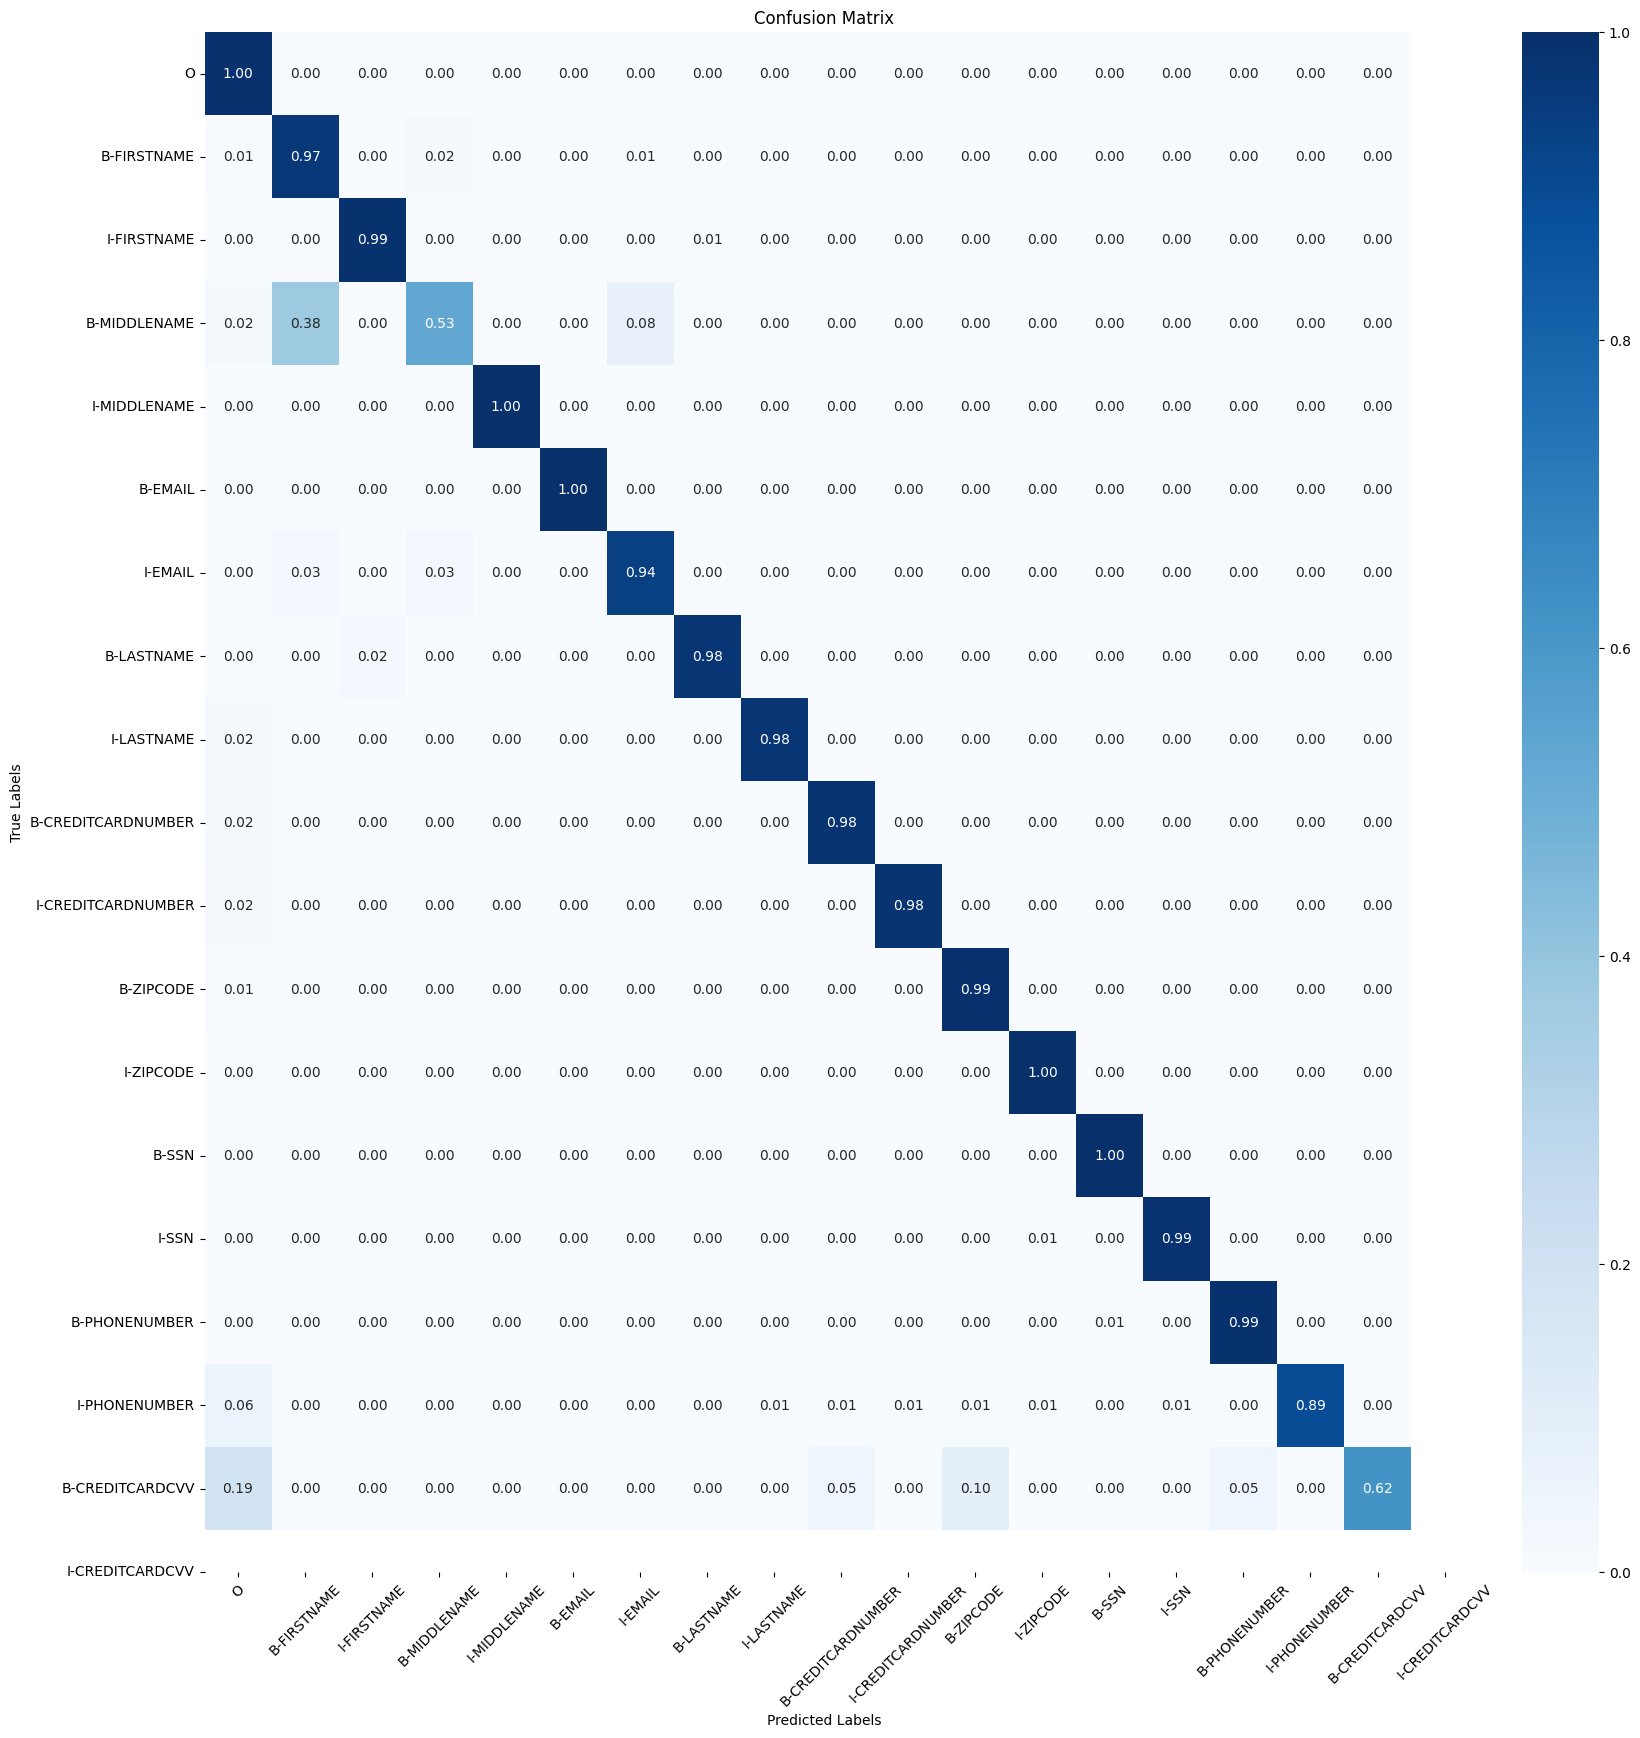

In [ ]:
from sklearn.metrics import confusion_matrix
#  Generate the confusion matrix
cm = confusion_matrix(filtered_labels, filtered_predictions,normalize='true')

# Plotting the confusion matrix
plt.figure(figsize=(20, 20))
ax= sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
# Ensure x-labels are vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Ensure y-labels are horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Checking Performance of Out of Box model

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "Isotonic/distilbert_finetuned_ai4privacy_v2"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)
token_classifier("Hi Mrs. Berge, remember to make payment for today's session. Use 16-digit card 2949686653378210 CVV 555.")

config.json:   0%|          | 0.00/5.78k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/266M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'entity_group': 'PREFIX',
  'score': 0.9600715,
  'word': 'mrs.',
  'start': 3,
  'end': 7},
 {'entity_group': 'LASTNAME',
  'score': 0.9723278,
  'word': 'berge',
  'start': 8,
  'end': 13},
 {'entity_group': 'SSN',
  'score': 0.56138664,
  'word': '2949686653378210',
  'start': 79,
  'end': 95},
 {'entity_group': 'CREDITCARDCVV',
  'score': 0.92387676,
  'word': '555',
  'start': 100,
  'end': 103}]

# Pipeline Output

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "/content/drive/MyDrive/data/models/pos/dbert/checkpoint-2000"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)
token_classifier("Hi Mrs. Berge, remember to make payment for today's session. Use 16-digit card 2949686653378210 CVV 555.")

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "/content/drive/MyDrive/data/models/pos/dbert_custom"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)
token_classifier("Hi Mrs. Berge, remember to make payment for today's session. Use 16-digit card 2949686653378210 CVV 555.")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity_group': 'LASTNAME',
  'score': 0.99496573,
  'word': 'Berge',
  'start': 7,
  'end': 13},
 {'entity_group': 'CREDITCARDNUMBER',
  'score': 0.9310213,
  'word': '2949686653378210',
  'start': 78,
  'end': 95},
 {'entity_group': 'CREDITCARDCVV',
  'score': 0.9761481,
  'word': '555',
  'start': 99,
  'end': 103}]